# Digits Classification using decision trees and random forests

This notebook explores how to use decision trees and it's ensemble model random forests to classify the MNIST dataset. MNIST is a dataset containing 70000 handwritten digits, split in a train and test set of 60000 and 10000 respectively. 

Usually, different algorithms would be used, such as convolutional neural networks. However, even basic data science algorithms like decision trees and random forests already do quite well on the data. 

As additional content for the HU Data Science for Business masterclass, this notebook explores those two classification methods.

In [1]:
from tensorflow.keras.datasets import mnist
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

(x_train_orig, y_train_all), (x_test_orig, y_test) = mnist.load_data()
x_train_all = x_train_orig.reshape(60000, 784)
x_test = x_test_orig.reshape(10000, 784)
x_train = x_train_all[:54000]
y_train = y_train_all[:54000]
x_dev = x_train_all[54000:]
y_dev = y_train_all[54000:]
print(x_train_orig.shape)
print(x_train.shape)
print(x_test.shape)
print(x_dev.shape)

(60000, 28, 28)
(54000, 784)
(10000, 784)
(6000, 784)


First we load the data and split it in a train, dev and test dataset. As the digits are pictures of 28 by 28 pixels, they need to be reshaped into 784 separate inputs.

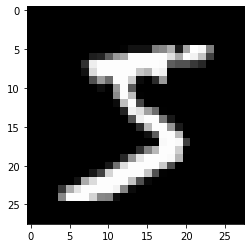

In [2]:
plt.imshow(x_train_orig[0], cmap='gray')

Inspecting of the first training example, we see a digit '5'. 

In [3]:
pd.Series(y_train).value_counts()

1    6112
7    5597
3    5504
9    5373
2    5358
6    5347
0    5336
8    5254
4    5247
5    4872
dtype: int64

All digits are present, although not all in the same frequency. 

Since we flattened the pictures, let's see if we can find some structure in the data by plotting some digits. Below you can find the first 1000 training examples of each digit. The pixels are stacked vertically. This means one vertical line equals one training example. one horizontal line represents the same pixel in each training example.

In [4]:
def PlotMnistHorizontal(digit):
    to_plot = x_train[y_train==digit][:1000].T
    plt.figure(figsize=(12,10))
    plt.title(f'First 1000 examples of digit {digit}')
    plt.imshow(to_plot, cmap='plasma')
    

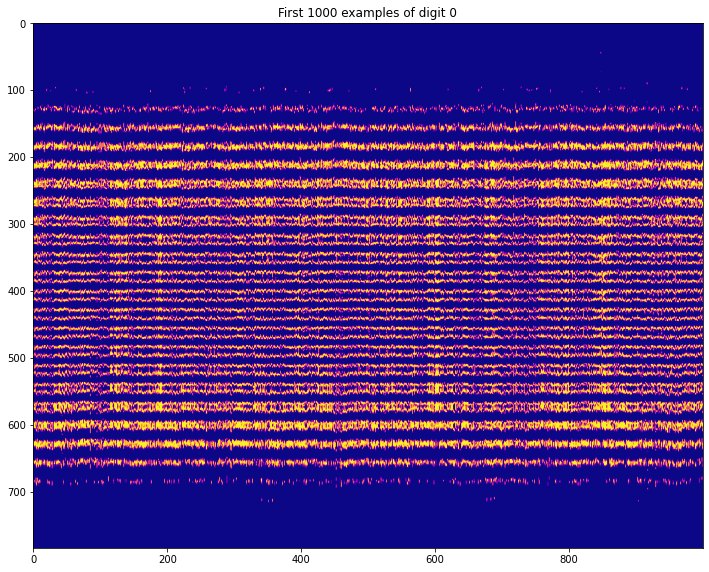

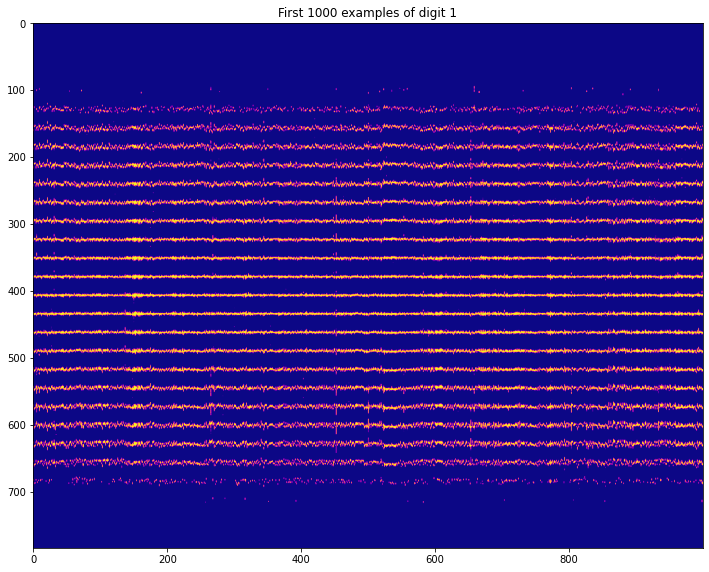

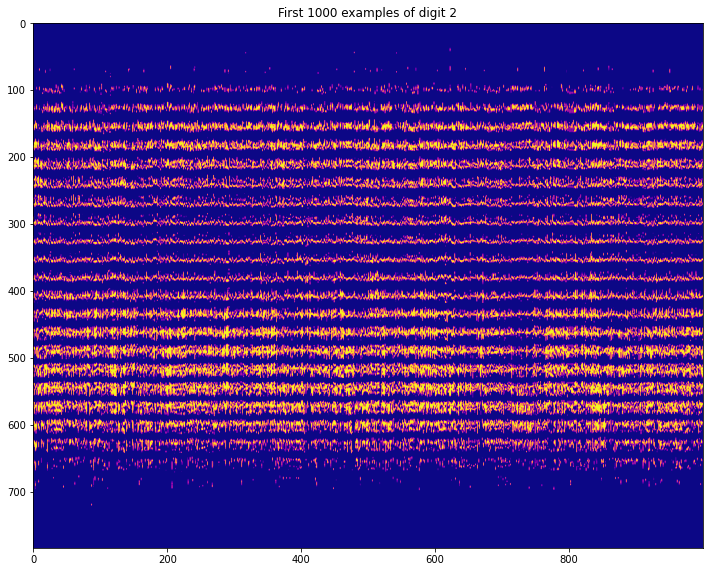

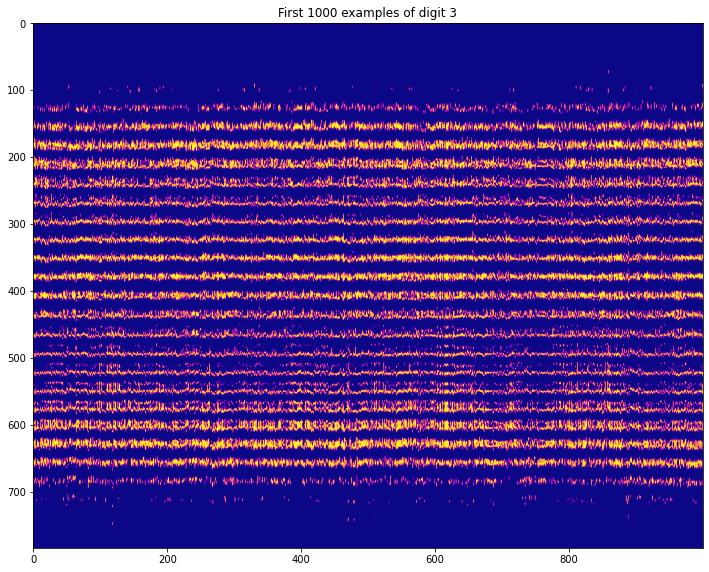

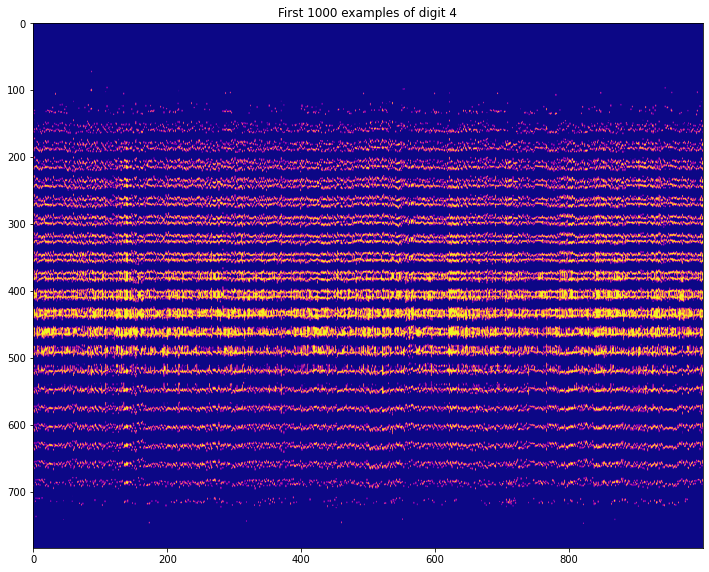

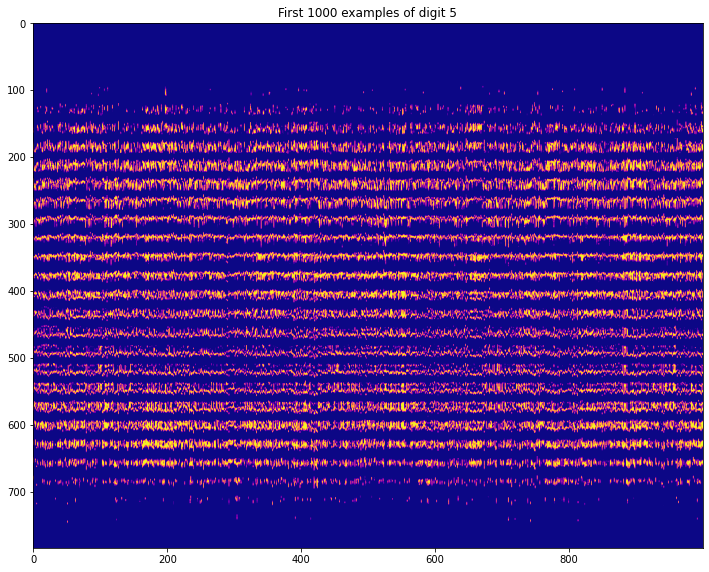

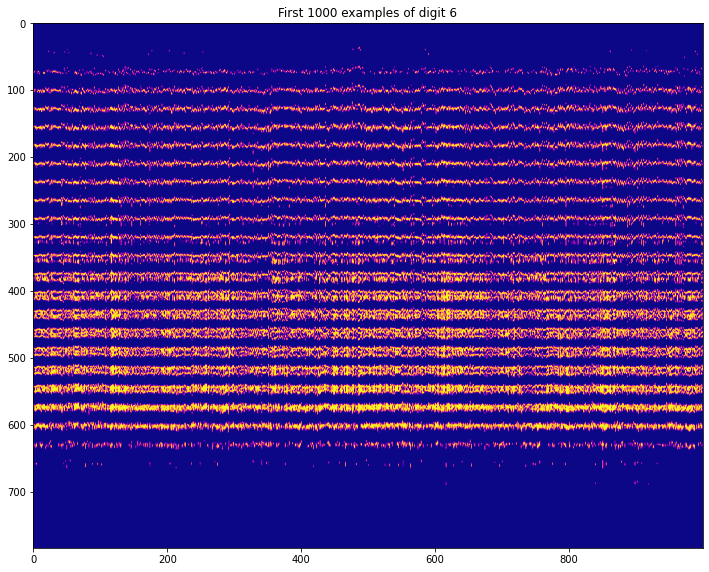

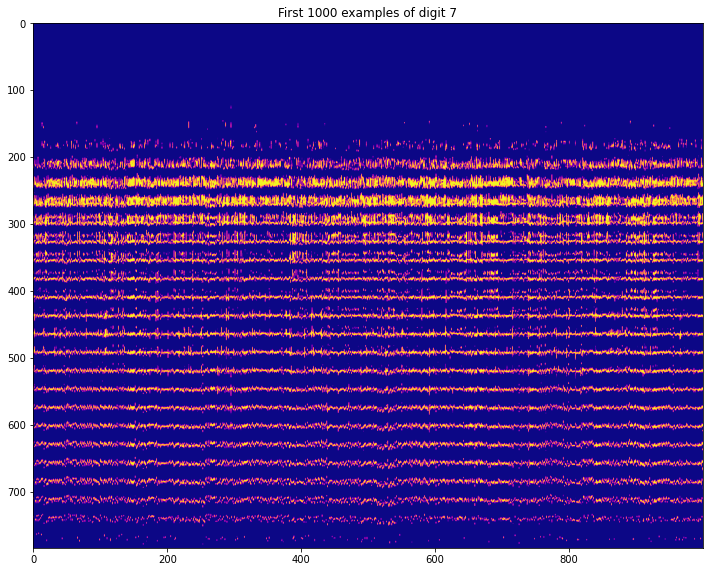

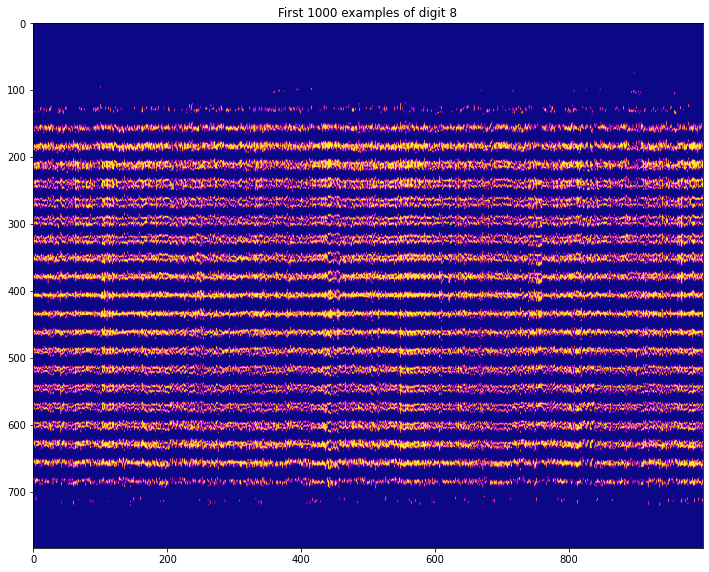

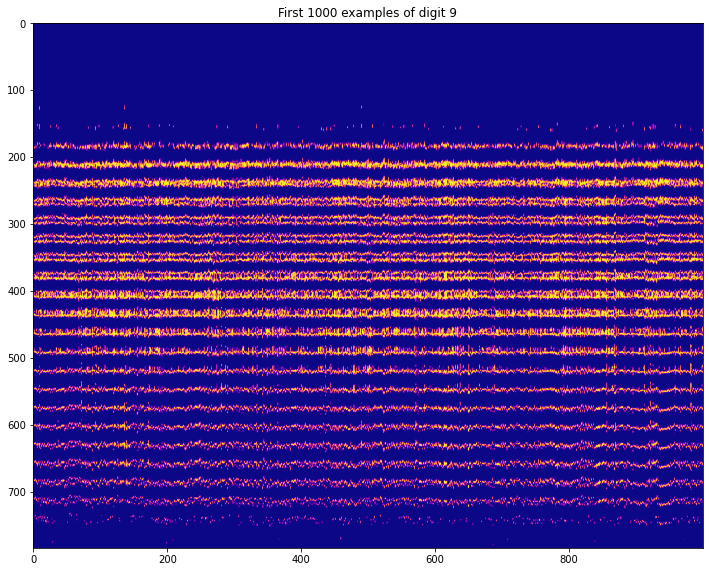

In [5]:
for d in range(0, 10):
    PlotMnistHorizontal(d)



## Decision Trees

As handled in the book Data Smart, Decision Trees can help classify examples based on input variables. First we see how scitkit-learns default settings handle the data.

Accuracy is 0.8748


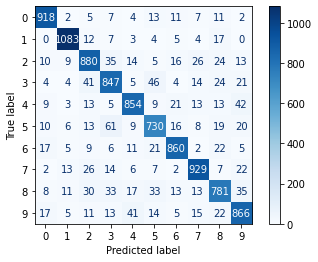

In [6]:
from sklearn import tree
from sklearn.metrics import confusion_matrix, accuracy_score, plot_confusion_matrix
## Using default settings

default_tree = tree.DecisionTreeClassifier(random_state=0)
default_tree = default_tree.fit(x_train, y_train)
cm = confusion_matrix(y_test, default_tree.predict(x_test))
acc = accuracy_score(y_test, default_tree.predict(x_test))

disp = plot_confusion_matrix(default_tree, x_test, y_test, cmap=plt.cm.Blues)

print(f'Accuracy is {acc}')


With an accuracy of 87,48% that's nothing to sneeze at. This means the decision tree is already able to distinguish between digits based on combinations of separate pixels. We discussed that trees have a certain depth, and have nodes, or leaves in them. Let's see how many were determined here.

In [7]:
print(default_tree.get_depth())
print(default_tree.get_n_leaves())

48
3680


A maximum depth of 48 was used, and results in 3680 leaves. That's a lot. As the maximum depth is a hyperparameter of the tree, let's see how accuracy depends on it. 

In [8]:


results = []

for d in range(1, 25):
    clf = tree.DecisionTreeClassifier(random_state=0, max_depth=d)
    clf.fit(x_train, y_train)
    train_acc = round(accuracy_score(y_train, clf.predict(x_train)),4)
    acc = round(accuracy_score(y_dev, clf.predict(x_dev)),4)
    results.append([d, acc, train_acc, clf.get_n_leaves()])


In [9]:
results = pd.DataFrame(results, columns=['depth', 'dev_accuracy', 'train_accuracy', 'n_leaves'])
results['perc_leaves_of_maximum'] = results.n_leaves / (2**results.depth)

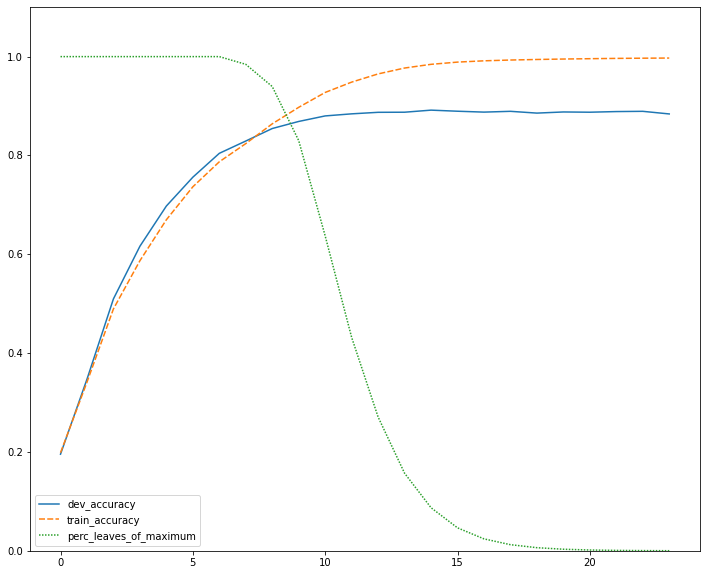

In [10]:
plt.figure(figsize=(12,10))
sns.lineplot(data=results[['dev_accuracy', 'train_accuracy', 'perc_leaves_of_maximum']])
plt.ylim(0, 1.1)
plt.show()

In the above line plot, three lines can be seen. The solid blue line is the accuracy on the development dataset, while the dashed orange line is the accuracy on the train dataset. They are comparable up until about a depth of 8 or 9, where the accruacy on the train dataset ends up higher than on the dev dataset. The dev dataset still increases, but with a lower slope. 

Furthermore, each step in depth has a split into two leaves. This means for 1 step, there are 2 leaves maximum, for 2 steps there are 4 leaves maximum, 3 turns into 8, and so forth. At some point, not all leaves are used anymore, so which is displayed in the green line. That shows the fraction of leaves that were used, out of the maximum. Once it starts declining from the maximum, the start of overfitting on train can also be seen. 

In order to balance accuracy on the dev dataset with complexity of the model, a maximum depth of 12 is chosen here.

Accuracy is 0.8773


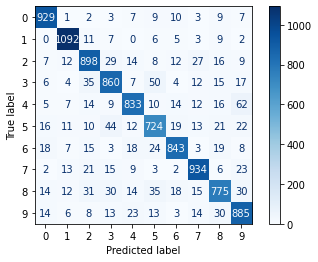

In [11]:
## final decision tree
decision_tree = tree.DecisionTreeClassifier(random_state = 0, max_depth=12)
decision_tree.fit(x_train, y_train)
cm = confusion_matrix(y_test, decision_tree.predict(x_test))
acc = accuracy_score(y_test, decision_tree.predict(x_test))

disp = plot_confusion_matrix(decision_tree, x_test, y_test, cmap=plt.cm.Blues)
print(f'Accuracy is {acc}')

An accuracy of 87.73% is reached with a model of max depth 12, compared to 87.48% in the default settings with max depth 48. In general, you want to reach the highest accuracy you can with the simplest model. It is a balancing act.

## Random forests

A different way of increasing accuracy is by using an ensemble model. Random forests use bagging as ensemble method, providing a subset of the data for each decision tree, and a subset of features. This allows certain trees to train on specific parts of the data, improving accuracy.

Let's start with the default settings. There is no restricion on max_depth, and 100 trees are trained.

In [12]:
## Random Forests

from sklearn.ensemble import RandomForestClassifier

rfc = RandomForestClassifier(random_state=0)
rfc.fit(x_train, y_train)


RandomForestClassifier(random_state=0)

Accuracy is 0.9768


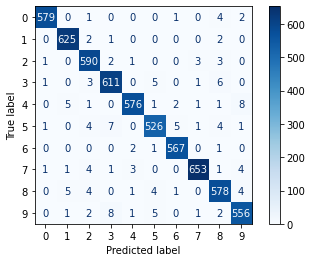

In [13]:
disp = plot_confusion_matrix(rfc, x_dev, y_dev, cmap=plt.cm.Blues)
acc = round( accuracy_score(y_dev, rfc.predict(x_dev)), 4)
print(f'Accuracy is {acc}')

With an accuracy of 97.68%, that's very high. Only about 1 in 30 is misclassified. Again, random forests have hyperparamters. Let's explore how they affect the accuracy of the models provided. That would take a long time to run without some parralization. That's used below. 

In [14]:
from multiprocessing import Pool, TimeoutError, cpu_count
from datetime import datetime
import time
import os
import rf
import inspect
from sklearn.ensemble import RandomForestClassifier

print(inspect.getsource(rf.randomForestInLoop))

def randomForestInLoop(i):
    from sklearn.ensemble import RandomForestClassifier
    from sklearn.metrics import confusion_matrix, accuracy_score, plot_confusion_matrix
    from tensorflow.keras.datasets import mnist
    import numpy as np
    import pandas as pd
    (x_train_orig, y_train_all), (x_test_orig, y_test) = mnist.load_data()
    x_train_all = x_train_orig.reshape(60000, 784)
    x_test = x_test_orig.reshape(10000, 784)
    x_train = x_train_all[:54000]
    y_train = y_train_all[:54000]
    x_dev = x_train_all[54000:]
    y_dev = y_train_all[54000:]
    
    n = round(i/1000)   ## Use this to transform input XXXYYY into XXX YYY
    m = i - (n * 1000)  ## Use this to transform input XXXYYY into XXX YYY
    rfc = RandomForestClassifier(random_state=0, n_estimators = n, max_depth = m)
    rfc.fit(x_train, y_train)
    train_acc = round(accuracy_score(y_train, rfc.predict(x_train)), 4)
    dev_acc = round(accuracy_score(y_dev, rfc.predict(x_dev)), 4)
    return([n, m, train_ac

In [15]:
iter_list = []
l = [1, 4, 9, 16, 25, 36, 49, 64, 81, 100, 121, 144]

for n_est in l:
    for m_depth in l:
        iter_list.append(1000*n_est + m_depth)

In [16]:
if __name__ ==  '__main__': 
    num_processors = 6
    p=Pool(processes = num_processors)
    output = p.map(rf.randomForestInLoop,iter_list)

In [17]:
rf_results = pd.DataFrame(output, columns=['n_estimators', 'max_depth', 'train_accuracy', 'dev_accuracy'])
print(rf_results)

     n_estimators  max_depth  train_accuracy  dev_accuracy
0               1          1          0.1977        0.1948
1               1          4          0.4435        0.4642
2               1          9          0.7455        0.7562
3               1         16          0.9119        0.8230
4               1         25          0.9274        0.8330
..            ...        ...             ...           ...
139           144         64          1.0000        0.9773
140           144         81          1.0000        0.9773
141           144        100          1.0000        0.9773
142           144        121          1.0000        0.9773
143           144        144          1.0000        0.9773

[144 rows x 4 columns]


The above dataframe contains train and dev accuracy for the trained forests. Let's plot those on a heatmap to see what's happening.

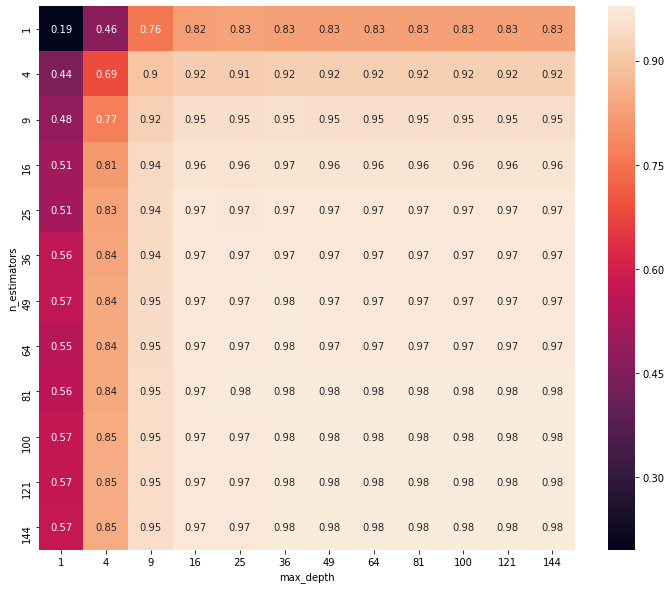

In [18]:
dev_pivot = rf_results.pivot(index='n_estimators', columns='max_depth', values='dev_accuracy')

plt.figure(figsize=(12,10))
ax = sns.heatmap(dev_pivot, annot=True)
plt.show()

It can be seen that there is a steep increase in accuracy going from the lower values to at least 16 depth and 16 trees. In fact, on that settings there is already a dev accuracy of 0.96. That can be further increased to 0.98. Based on the above heatmap, I'd pick about 100 estimates with a depth of 64.

If you look at the accuracy of the train dataset however, you can see that that accuracy reaches 1 very quickly and there is no way to differentiate anymore. This is why having a dev dataset is so valuable in training.

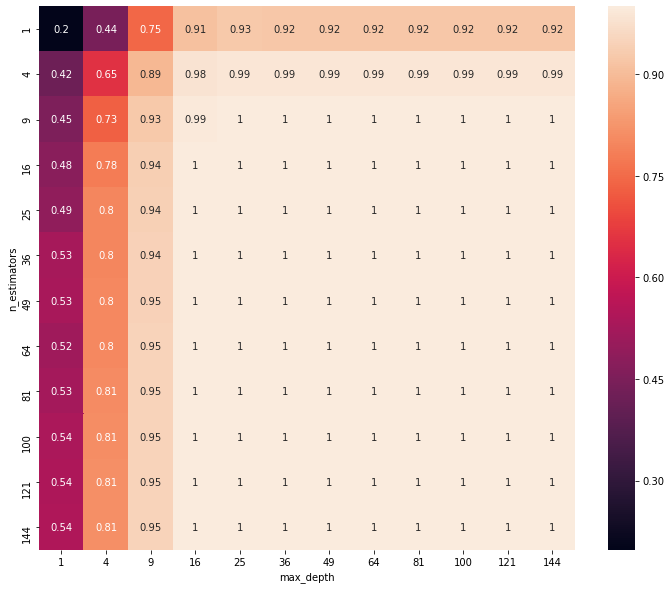

In [19]:
tr_pivot = rf_results.pivot(index='n_estimators', columns='max_depth', values='train_accuracy')
plt.figure(figsize=(12,10))
ax = sns.heatmap(tr_pivot, annot=True)
plt.show()

Accuracy is 0.9689


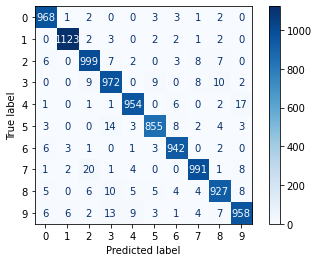

In [21]:
# n_estimators = 100
# max_depth = 64
rfc = RandomForestClassifier(random_state=0, n_estimators = 100, max_depth = 64)
rfc.fit(x_train, y_train)
disp = plot_confusion_matrix(rfc, x_test, y_test, cmap=plt.cm.Blues)
acc = accuracy_score(y_test, rfc.predict(x_test))
print(f'Accuracy is {acc}')

We end up with an accuracy of 96.89% using these hyperparameters.